# RNN
Traite l'ensemble des noeuds de l'arbre séquentiellement.

On commence par demander la valeur du parent le plus haut.
On demande ensuite la valeur de chacun des fils à partir des features du noeud parent et de chaque fils.
A chaque nouveau parent, on met à jour l'état interne du modèle, grâce au RNN.

In [1]:
%%time

import os

import pylab
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sb_utils.read_data import get_trees

path = 'data/second_samples/normalized/train/'
trees = get_trees(path)
total_len = sum([len(t) for t in trees.values()])
print(f'Number of parents: {total_len:,}')

Number of parents: 27,873
Wall time: 1min 8s


In [2]:
from sklearn.model_selection import train_test_split

def tree_to_dataset(tree, number_of_childs=5):
    """
    Retourne dans l'ordre le couple (parent_features, childs_features, childs_values).
    Le premier enfant de la liste est toujours le parent de la liste suivante.
    """
    parents, childs, values = [], [], []
    parent_order = [node_id for node_id in sorted(tree.keys())]
    
    for parent_id in parent_order:
        parent_node = tree[parent_id]
        feature_names = sorted(parent_node.features.keys())
        childs_features = []
        childs_values = []
        
        if len(parent_node.children_nodes) != number_of_childs:
            continue  # Invalid parent
        
        next_parent = -1
        for child_number, child in enumerate(parent_node.children_nodes):
            child_row = np.array([child.features[f] for f in feature_names])
            childs_features.append(child_row)
            childs_values.append(child.value)
            
            if child.children_nodes:
                next_parent = child_number
        
        childs_features = np.array(childs_features)
        # Place le futur parent à la première position
        childs_features[0, ], childs_features[next_parent, ] = childs_features[next_parent, ], childs_features[0, ]
        
        childs.append(childs_features)
        values.append(np.array(childs_values))
        parents.append(np.array([parent_node.features[f] for f in feature_names]
                                + [parent_node.value]))
        
    return np.array(parents), np.array(childs), np.array(values)

def build_dataset(trees):
    parents, childs, values = [], [], []
    for tree in trees.values():
        parents_t, childs_t, values_t = tree_to_dataset(tree)
        if childs_t.shape[0] != 0:
            childs.append(childs_t)
            values.append(values_t)
            parents.append(parents_t)
    
    return parents, childs, values

parents, childs, values = build_dataset(trees)
stages_number = [len(p) for p in parents]
print(f'Number of datasets: {len(childs): ,}')
print(f'Mean number of stages: {np.mean(stages_number):.2f} (std of {np.std(stages_number):.2f})')
print(f'Number of features (childs): ({childs[0].shape[1]}, {childs[0].shape[2]})')
print(f'Number of features (parents): {parents[0].shape[1]}\n')

X = [(p, c) for p, c in zip(parents, childs)]
X_train, X_test, y_train, y_test = train_test_split(X, values, test_size=0.2)
childs_train, childs_test = [x[1] for x in X_train], [x[1] for x in X_test]
parents_train, parents_test = [x[0] for x in X_train], [x[0] for x in X_test]
print(f'Number of training examples: {len(childs_train): ,}')
print(f'Number of validation examples: {len(childs_test): ,}')

Number of datasets:  306
Mean number of stages: 89.45 (std of 69.58)
Number of features (childs): (5, 12)
Number of features (parents): 13

Number of training examples:  244
Number of validation examples:  62


In [3]:
import torch

class Dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, parents, childs, values):
        self.parents = [torch.FloatTensor(p) for p in parents]
        self.childs = [torch.FloatTensor(c) for c in childs]
        self.values = [torch.FloatTensor(v) for v in values]
        self.number_of_nodes = self.childs[0].shape[1]
        self.n_features = self.childs[0].shape[1] * self.childs[0].shape[2] + self.parents[0].shape[1]
        
    def __len__(self):
        return len(self.childs)

    def __getitem__(self, index):
        return self.parents[index], self.childs[index], self.values[index]


train_dataset = Dataset(parents_train, childs_train, y_train)
test_dataset = Dataset(parents_test, childs_test, y_test)

# Fonctions d'entraînement
L'entraînement est particulier. On entraîne le modèle sur un batch d'arbre B&B.

Pour chaque arbre, on effectue d'abord la prédiction pour le premier noeud parent, en actualisant au passage les variables cachées du LSTM.
Ensuite, on prédit à chaque fois la valeur des enfants, en utilisant les états cachés du LSTM provenant de la prédiction du parent directe des noeuds.
On continue ainsi jusqu'à avoir prédit l'entiereté des arbres.

Finalement, on traite un batch d'arbre en parallèle.

In [4]:
def precision(val, pred):
    """
    Retourne la précision entre la valeur val et la valeur
    prédite pred.
    Pourcentage entre 0 et beaucoup (si pred est très loin de val).
    """
    return abs(val - pred)

def loss_first_parents(model, parents, values,
                       criterion):
    """
    Entraînement sur les premiers parents de l'arbre.
    On remplit les features manquantes avec des 0.
    
    'parents' est un batch contenant les features des premiers parents.
    'values' est le batch correspondant aux valeurs des premiers parents.
    """
    batch_size = parents.shape[0]
    fill_parents = torch.zeros((batch_size, model.input_size - parents.shape[1])).to(parents.device)
    parents = torch.cat([
        fill_parents, parents
    ], axis=1)
    
    pred, hidden = model(parents)
    loss = criterion(pred, values)
    prec = np.mean([
        precision(v.item(), p.item())
        for v, p in zip(values.view(-1), pred.view(-1))
    ])
    return hidden, loss, prec

def loss_childs(model, parents, childs, values,
                hidden, criterion):
    """
    Entraînement sur le batch d'enfants donné.
    Retourne le nouvel hidden state, le loss de l'entraînement,
    et la précision.
    
    'parents' est un batch contenant les features des parents.
    'childs' est un batch contenant les features de tous les enfants des parents (5 enfants par parent généralement).
    'values' est un batch contenant les valeurs du batch d'enfants.
    'hidden' est le batch des hidden states (1 hidden par parent).
    
    Gère un nombre variable d'enfants par parent.
    """
    input_batch = []
    hidden_batch = []
    next_parents = []
    for i in range(len(parents)):
        input_batch.extend([
            torch.cat((parents[i].clone(), childs[i, j]), axis=0)  # [parent_features, enfant_features]
            for j in range(len(childs[i]))  # Pour chaque enfant du parent i
        ])
        
        hidden_batch.extend([
            hidden[:, :, i, :].clone()  # Copie le hidden state du parent
            for _ in range(len(childs[i]))  # 1 par enfant
        ])
        
        next_parents.append(len(childs[i]))  # De combien il faut se décaler pour trouver le prochain parent
        
    hidden_batch = torch.stack(hidden_batch, dim=2)  # La dimension du batch_size est dim=2
    input_batch = torch.stack(input_batch, dim=0)
    next_p, next_parents[0] = next_parents[0], 0
    for i in range(1, len(next_parents)):
        next_p, next_parents[i] = next_parents[i], next_parents[i-1] + next_p
    
    values = values.view(-1, 1)
    pred, hidden = model(input_batch, hidden_batch)
    
    loss = criterion(pred, values)
    
    hidden = torch.stack([
        hidden[:, :, p, :]
        for p in next_parents  # Contient les indices des prochains parents
    ], dim=2)
    
    prec = [
        precision(v.item(), p.item())
        for v, p in zip(values.view(-1), pred.view(-1))
    ]
    
    return hidden, loss, prec

def loss_batch(model, batch, criterion, cuda):
    """
    Calcule le loss du batch donné.
    Met en forme les données du batch pour utiliser les fonctions
    'loss_first_parents' et 'loss_childs'.
    
    Retourne aussi la précision du modèle.
    """
    precision = []
    
    ### Entraîne un premier coup sur les premiers parents
    parents = torch.stack([
        tree[0][0, :]  # Premier parent de l'arbre
        for tree in batch  # Pour chaque arbre
    ], dim=0)

    if cuda:
        parents = parents.cuda()

    parents, values = parents[:, :-1], parents[:, -1:]
    hidden, loss, prec = loss_first_parents(model, parents, values, criterion)
    precision.append(prec)

    ### Entraîne sur tous les étages suivants
    max_stages = max(len(tree[0]) for tree in batch)  # Nombre max d'étages parmi le batch
    hidden_size = hidden.shape
    for stage_num in range(max_stages):
        # Numéros des arbres valides pour le stage courant
        available_trees = [i for i in range(len(batch))
                           if stage_num < len(batch[i][0])]

        parents = torch.stack([
            batch[i][0][stage_num, :]
            for i in available_trees
        ], dim=0)

        childs = torch.stack([
            batch[i][1][stage_num, :, :]
            for i in available_trees
        ], dim=0)

        values = torch.stack([
            batch[i][2][stage_num, :]
            for i in available_trees
        ], dim=0)

        hidden = torch.stack([
            hidden[:, :, i, :]
            for i in available_trees
        ], dim=2)

        if cuda:
            parents = parents.cuda()
            childs = childs.cuda()
            values = values.cuda()

        hidden_t, loss_t, prec = loss_childs(model, parents, childs,
                                       values, hidden, criterion)

        loss += loss_t  # Ajoute aux loss précédents

        # Reconstruit hidden de sorte à ce qu'il ait tout le temps la même taille (sinon available tree n'est plus réaliste)
        hidden = torch.zeros(hidden_size).to(hidden_t.device)
        for hid_t_idx, avai_idx in enumerate(available_trees):
            hidden[:, :, avai_idx, :] = hidden_t[:, :, hid_t_idx, :]
        
        precision.extend(prec)
    
    return loss, precision

def eval_dataset(model, criterion, dataloader, cuda):
    """
    Evalue le modèle sur le dataloader donné.
    Retourne le loss et la précision du modèle.
    """
    model.eval()
    losses = []
    precisions = []
    
    if cuda:
        model = model.cuda()
        # criterion = criterion.cuda()
    
    for batch in dataloader:
        loss, prec = loss_batch(model, batch, criterion, cuda)
        losses.append(loss.item())
        precisions.extend(prec)
    
    return np.mean(losses), np.mean(precisions), np.std(precisions)

def train(model, data_train, data_val,
          criterion, optimizer, scheduler, epochs,
          print_each=1, cuda=True):
    """
    Entraîne le modèle pour le nombre d'epochs donné.
    """
    train_loss, train_prec = [], []
    val_loss, val_prec = [], []
    
    cuda = cuda and torch.cuda.is_available()
    if cuda:
        model = model.cuda()
        # criterion = criterion.cuda()
    else:
        model = model.cpu()
        # criterion = criterion.cpu()
    
    for e in range(1, epochs+1):
        model.train()
        for batch in data_train:
            optimizer.zero_grad()
            
            loss, _ = loss_batch(model, batch, criterion, cuda)
            
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        
        
        if e % print_each == 0:
            loss, prec, std_prec_t = eval_dataset(model, criterion, data_train, cuda)
            train_loss.append(loss)
            train_prec.append(prec)

            loss, prec, std_prec_v = eval_dataset(model, criterion, data_val, cuda)
            val_loss.append(loss)
            val_prec.append(prec)
            
            print(f'Epoch {e}')
            print(f'Train loss: {train_loss[-1]:.5f} \t\t\t\t\tVal loss: {val_loss[-1]:.5f}')
            print(f'Train precision: {train_prec[-1]:.2e} ({std_prec_t:.2e})\
                  \tVal precision: {val_prec[-1]:.2e} ({std_prec_v:.2e})')
    
    return train_loss, train_prec, val_loss, val_prec

In [5]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers, n_res_layers):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.first_layer = nn.LSTMCell(input_size, hidden_size // 4)
        self.layer_norm = nn.LayerNorm(hidden_size // 4)
        self.transition = nn.Linear(hidden_size // 4, hidden_size)
        
        self.n_layers = n_layers
        self.deep_layers = [
            nn.ModuleList([
                nn.LSTMCell(hidden_size, hidden_size),
                nn.LayerNorm(hidden_size),
            ])
            for _ in range(n_layers)
        ]
        self.deep_layers = nn.ModuleList(self.deep_layers)
        
        self.res_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.SELU(),
            )
            for _ in range(n_res_layers)
        ])
        
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, inpt, saved_states=None):
        """
        saved_states are the hidden states.
        Can be None, which is useful for the torchsummary.
        """
        if saved_states is None:
            saved_states = self.init_hidden(inpt.shape[0]).to(inpt.device)
        
        hidden, memory = saved_states[0], saved_states[1]
        
        last_hidden = []
        last_memory = []
        
        h, c = self.first_layer(inpt, (hidden[0], memory[0]))
        last_hidden.append(h)
        last_memory.append(c)
        
        h = self.layer_norm(h)
        h = self.transition(h)
        
        for layer_id in range(1, self.n_layers+1):
            lstm_cell, layer_norm = self.deep_layers[layer_id-1][0], self.deep_layers[layer_id-1][1]
            
            h, c = lstm_cell(h, (hidden[layer_id], memory[layer_id]))
            last_hidden.append(h)
            last_memory.append(c)
            
            h = layer_norm(h)
        
        for res_layer in self.res_layers:
            h = h + res_layer(h)
        
        output = self.output_layer(h)
        
        saved_states = torch.stack([
            torch.stack(last_hidden),
            torch.stack(last_memory),
        ])
        return torch.sigmoid(output), saved_states
    
    def init_hidden(self, batch_size):
        """
        Initialize the hidden states and the memory cells.
        Thats why the shape is (2, n_layers+1, batch_size, hidden_size).
        """
        return torch.zeros(2, self.n_layers+1, batch_size, self.hidden_size // 4)

def RNN_criterion(pred, values):
    """
    Logloss pour profiter du fait que la sortie soit
    une sigmoid.
    """
    ones = torch.ones(values.shape).to(values.device)
    loss = torch.log(ones - torch.abs(pred - values) + 1e-6).view(-1)
    return -torch.mean(loss)

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader

from torchsummary import summary

batch_size = 20
input_size = train_dataset[0][0][0].shape[0] + train_dataset[0][1][0].shape[1]
output_size = 1

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=list)
data_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=list)

n_layers = 0
n_res_layers = 3
n_hidden = 1000
model = LSTM(input_size, output_size, n_hidden, n_layers, n_res_layers)

lr = 1e-4
step_lr = 60
gamma = 0.1
criterion = RNN_criterion
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_lr, gamma=gamma)

_ = summary(model, (input_size, ))

Layer (type:depth-idx)                   Output Shape              Param #
├─LSTMCell: 1-1                          [-1, 250]                 277,000
├─LayerNorm: 1-2                         [-1, 250]                 500
├─Linear: 1-3                            [-1, 1000]                251,000
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-1                   [-1, 1000]                --
|    |    └─Linear: 3-1                  [-1, 1000]                1,001,000
|    |    └─SELU: 3-2                    [-1, 1000]                --
|    └─Sequential: 2-2                   [-1, 1000]                --
|    |    └─Linear: 3-3                  [-1, 1000]                1,001,000
|    |    └─SELU: 3-4                    [-1, 1000]                --
|    └─Sequential: 2-3                   [-1, 1000]                --
|    |    └─Linear: 3-5                  [-1, 1000]                1,001,000
|    |    └─SELU: 3-6                    [-1, 1000]  

In [7]:
%%time
epochs = 50
print_each = 5
perfs = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, scheduler, epochs,
              print_each=print_each, cuda=True)

Epoch 5
Train loss: 9.63432 					Val loss: 8.35412
Train precision: 4.46e-02 (5.41e-02)                  	Val precision: 4.17e-02 (5.39e-02)
Epoch 10
Train loss: 8.35146 					Val loss: 7.00779
Train precision: 3.92e-02 (5.48e-02)                  	Val precision: 3.58e-02 (5.41e-02)
Epoch 15
Train loss: 8.62592 					Val loss: 6.18340
Train precision: 3.88e-02 (5.03e-02)                  	Val precision: 3.54e-02 (4.84e-02)
Epoch 20
Train loss: 7.31782 					Val loss: 5.90639
Train precision: 3.35e-02 (5.09e-02)                  	Val precision: 2.99e-02 (4.95e-02)
Epoch 25
Train loss: 7.92693 					Val loss: 6.37629
Train precision: 3.67e-02 (5.17e-02)                  	Val precision: 3.24e-02 (4.99e-02)
Epoch 30
Train loss: 14.17589 					Val loss: 13.92158
Train precision: 6.01e-02 (6.99e-02)                  	Val precision: 5.78e-02 (7.09e-02)
Epoch 35
Train loss: 6.92148 					Val loss: 5.25898
Train precision: 3.19e-02 (5.05e-02)                  	Val precision: 2.82e-02 (4.89e-02)
Epoch

# Visualisation des performances

In [8]:
pylab.rcParams['figure.figsize'] = (10, 4)  # Make plots bigger

def plot_perfs(train_loss, train_acc, val_loss, val_acc,
               print_each, model_name):
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_loss)+1), train_loss, label='Train loss')
    plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('BCE Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_acc)+1), train_acc, label='Train precision')
    plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Precision')
    plt.legend()

    plt.suptitle(f'{model_name} score over epochs')
    plt.show()

    print(f'Final loss: {val_loss[-1]: .3f}')
    print(f'Final precision: {val_acc[-1]: .2e}')

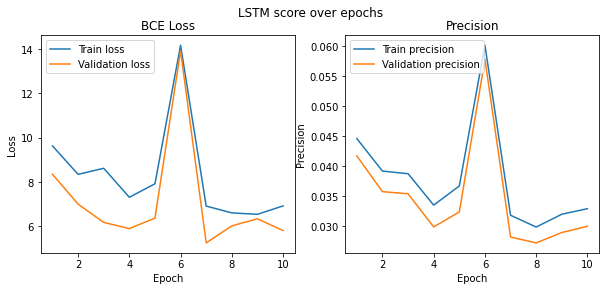

Final loss:  5.816
Final precision:  3.00e-02


In [9]:
plot_perfs(*perfs, print_each, 'LSTM')